## Notebook for analyzing the GSOD data (taking the station KLAX for example)

Author: Wenwen Kong

Updated: 2022-07-17

### Purpose of the notebook
- Demonstrate two approaches of obtaining seasonal cycle (emperical long-term average versus FFT)

### Credits:
- Followed Isla's code ([function](https://github.com/islasimpson/CASanalysis/blob/main/CASutils/filter_utils.py), [example](https://github.com/islasimpson/CASanalysis/blob/main/examples/outputera5deseas.ipynb)) to obtain seasonal cycle using the FFT

---

### Load useful libraries 

In [1]:
import numpy as np
from scipy.fft import fft, ifft
import xarray as xr
import sys
import pandas as pd
import glob
import matplotlib.pyplot as plt

#### Read in the data

In [2]:
site    = 'KLAX'
years   = list(range(1973, 2022))
yrStart = years[0]
yrEnd   = years[-1]
file    = 'GSOD_'+site+'_'+str(yrStart)+'-'+str(yrEnd)+'_cleaned.csv'

col_list= ['YEARMODA', 'YEAR', 'MONTH', 'DAY','NAME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'MAX', 'MIN']

df         = pd.read_csv(file, usecols = col_list)
df

,YEARMODA,NAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,TEMP,MAX,MIN
0,1973-01-01,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,1,14.8,19.4,11.1
1,1973-01-02,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,2,12.6,17.8,7.2
2,1973-01-03,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,3,11.8,15.0,8.9
3,1973-01-04,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,4,10.8,13.9,7.2
4,1973-01-05,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,5,8.0,15.0,2.8
...,...,...,...,...,...,...,...,...,...,...
17880,2021-12-27,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,27,10.2,14.4,6.7
17881,2021-12-28,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,28,11.3,12.8,6.7
17882,2021-12-29,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,29,10.0,12.8,7.2
17883,2021-12-30,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,30,11.7,13.3,7.2


#### Empericial climatology, and the anomalies 

In [3]:
# **********************************************************************************************
#     TEMP_clim, TEMP_anom
# **********************************************************************************************
df['TEMP_emperical_clim'] = df.groupby(['MONTH', 'DAY'])['TEMP'].transform('mean')
df['TEMP_emperical_anom'] = df['TEMP'] - df['TEMP_emperical_clim']


#### FFT method 

In [4]:
# ---- Read in the calculated emperical climatology
# ---- And convert to data array

df_array = np.array(df['TEMP_emperical_clim'])
df_clim  = df_array[0:365]

ntime    = 365
nharms   = 4

temp_fft = fft(df_clim, axis = 0)
temp_fft2= np.zeros_like(temp_fft)
temp_fft2[0:nharms] = temp_fft[0:nharms]
temp_fft2[ntime-nharms+1:ntime+1] = temp_fft[ntime-nharms+1:ntime+1]

df_array_filtered = np.real(ifft(temp_fft2, axis=0))
df_seasonal_cycle = xr.DataArray(df_array_filtered)


# ---- To add a new column in df that contains the df_seasonal_cycle, repeated nyears times
repeats      = int(len(df['TEMP']) / 365)
repeats_list = []

for i in range(0,repeats):
    repeats_list.extend(df_seasonal_cycle)

df['TEMP_fft_clim'] = xr.DataArray(repeats_list)
df['TEMP_fft_anom'] = df['TEMP'] - df['TEMP_fft_clim']


#### Look at the new df

In [5]:
df

,YEARMODA,NAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,TEMP,MAX,MIN,TEMP_emperical_clim,TEMP_emperical_anom,TEMP_fft_clim,TEMP_fft_anom
0,1973-01-01,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,1,14.8,19.4,11.1,13.048980,1.751020,13.659650,1.140350
1,1973-01-02,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,2,12.6,17.8,7.2,13.363265,-0.763265,13.644411,-1.044411
2,1973-01-03,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,3,11.8,15.0,8.9,13.602041,-1.802041,13.630885,-1.830885
3,1973-01-04,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,4,10.8,13.9,7.2,13.534694,-2.734694,13.619041,-2.819041
4,1973-01-05,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,1973,1,5,8.0,15.0,2.8,13.653061,-5.653061,13.608848,-5.608848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17880,2021-12-27,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,27,10.2,14.4,6.7,12.848980,-2.648980,13.762419,-3.562419
17881,2021-12-28,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,28,11.3,12.8,6.7,13.155102,-1.855102,13.738246,-2.438246
17882,2021-12-29,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,29,10.0,12.8,7.2,13.289796,-3.289796,13.715903,-3.715903
17883,2021-12-30,LOS ANGELES INTERNATIONAL AIRPORT,33.938,-118.389,2021,12,30,11.7,13.3,7.2,13.226531,-1.526531,13.695371,-1.995371


#### Comparing the emperical seasonal cycle and the fft filtered seasonal cycle

For simplicity, we will only plot out the first few years' data

The following plot suggests that the fft filtered seasonal cycle is much smoother! 

<AxesSubplot:>

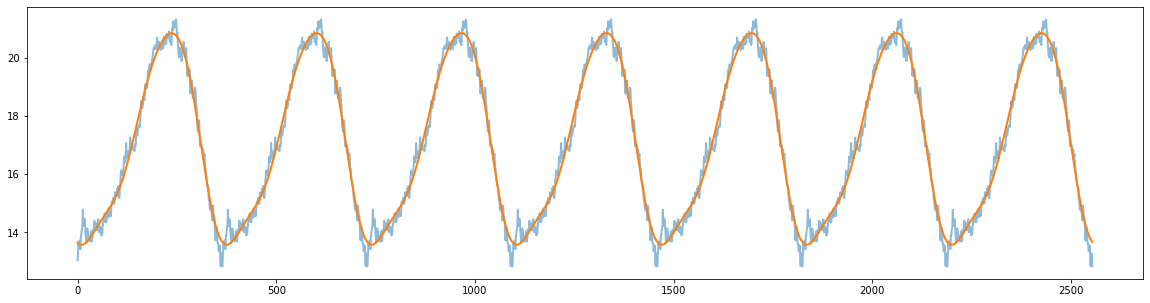

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
df[df.YEAR < 1980]['TEMP_emperical_clim'].plot(ax = ax, lw = 2, color = 'tab:blue', alpha = .5)
df[df.YEAR < 1980]['TEMP_fft_clim'].plot(ax = ax, lw = 2, color = 'tab:orange', alpha = 1.0)


#### What about the daily anomalies?

Daily anomalies obtained from the two approaches are almost identical! 

<AxesSubplot:>

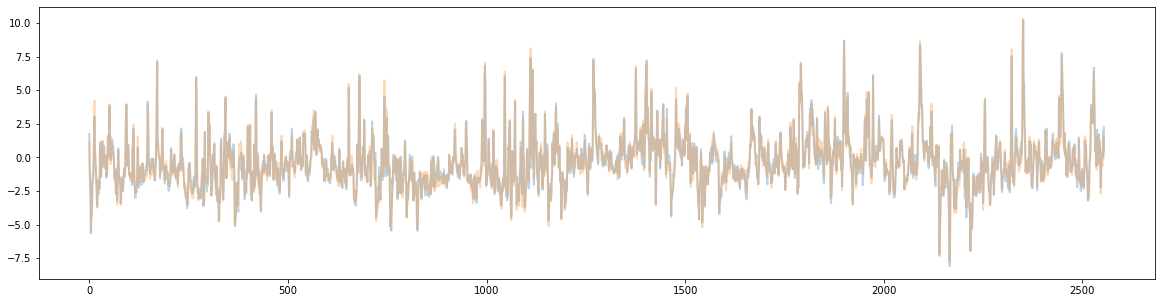

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
df[df.YEAR < 1980]['TEMP_emperical_anom'].plot(ax = ax, lw = 2, color = 'tab:blue', alpha = .3)
df[df.YEAR < 1980]['TEMP_fft_anom'].plot(ax = ax, lw = 2, color = 'tab:orange', alpha = .3)

--- 
### Below is a to do list for future analyais

- #### Stations on the map 

    - Let's get a sense of where the four stations locate. 

    - Resource: 
        - https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy


- #### Linear regression 


- #### Quantile regression 
    - See whether we can reproduce McKinnon et al 2016 JGR Figure 3 with our data
    - Examples:
        - https://stackoverflow.com/questions/55069984/matplotlib-inset-plot-within-basemap
        - https://www.pygmt.org/v0.3.0/tutorials/inset.html
        - https://basemaptutorial.readthedocs.io/en/latest/locator.html
    

